This project is to get familiar with some GCP services.

GPU accerator is being used

In [1]:
import tensorflow as tf
from IPython.display import Image, display

import matplotlib.pyplot as plt
import tensorflow_hub as hub

import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
!nvidia-smi

Mon Dec  5 13:13:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

--2022-12-05 13:20:58--  https://storage.googleapis.com/ibeans/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.128, 142.251.16.128, 142.250.65.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M  66.0MB/s    in 2.1s    

2022-12-05 13:21:00 (66.0 MB/s) - ‘train.zip’ saved [143812152/143812152]

--2022-12-05 13:21:00--  https://storage.googleapis.com/ibeans/validation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.128, 142.251.16.128, 142.250.65.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[=================

In [8]:
!mkdir beans

In [9]:
!unzip train.zip -d beans/
!unzip test.zip -d beans/
!unzip validation.zip -d beans/

Archive:  train.zip
   creating: beans/train/
   creating: beans/train/healthy/
   creating: beans/train/angular_leaf_spot/
   creating: beans/train/bean_rust/
  inflating: beans/train/healthy/healthy_train.265.jpg  
  inflating: beans/train/healthy/healthy_train.271.jpg  
  inflating: beans/train/healthy/healthy_train.259.jpg  
  inflating: beans/train/healthy/healthy_train.99.jpg  
  inflating: beans/train/healthy/healthy_train.311.jpg  
  inflating: beans/train/healthy/healthy_train.66.jpg  
  inflating: beans/train/healthy/healthy_train.72.jpg  
  inflating: beans/train/healthy/healthy_train.305.jpg  
  inflating: beans/train/healthy/healthy_train.339.jpg  
  inflating: beans/train/healthy/healthy_train.113.jpg  
  inflating: beans/train/healthy/healthy_train.107.jpg  
  inflating: beans/train/healthy/healthy_train.106.jpg  
  inflating: beans/train/healthy/healthy_train.112.jpg  
  inflating: beans/train/healthy/healthy_train.338.jpg  
  inflating: beans/train/healthy/healthy_trai

In [10]:
!ls beans

test  train  validation


In [11]:
!find beans -type f | wc -l

1296


In [12]:
!find beans/test -type f | wc -l 

128


In [13]:
!find beans/validation -type f | wc -l 

133


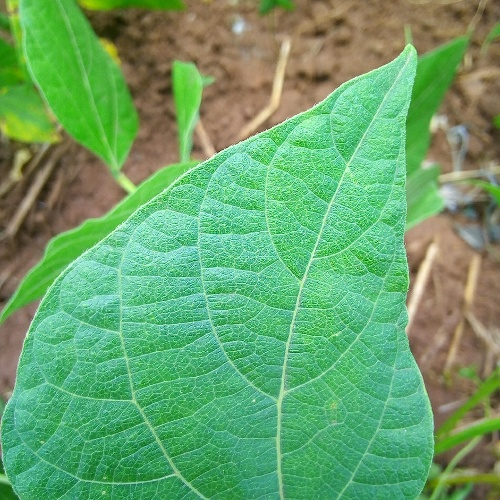

In [14]:
display(Image('beans/train/healthy/healthy_train.0.jpg'))

In [15]:
batch_size = 128
img_height = 224
img_width = 224

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/train',
                                                               seed = 121,
                                                               image_size = (img_height,img_width),
                                                               batch_size = batch_size)

Found 1034 files belonging to 3 classes.


In [17]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/test',
                                                               seed = 121,
                                                               image_size = (img_height,img_width),
                                                               batch_size = batch_size)

Found 128 files belonging to 3 classes.


In [18]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/validation',
                                                               seed = 121,
                                                               image_size = (img_height,img_width),
                                                               batch_size = batch_size)

Found 133 files belonging to 3 classes.


In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [20]:
classes = train_ds.class_names
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


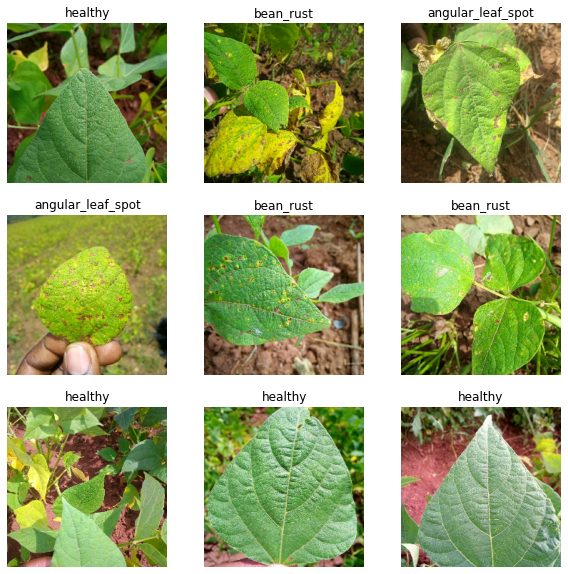

In [21]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis('off')

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [22]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [30]:
feature_extractor_layer = hub.KerasLayer(feature_extractor,input_shape=(img_height,img_width,3))

In [31]:
feature_extractor_layer.trainable  = False

In [27]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [28]:
tf.random.set_seed(111)

In [32]:
model = tf.keras.Sequential([
    normalization_layer,
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3,activation='softmax')
])

In [33]:
model.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [36]:
history = model.fit(train_ds, epochs=20, validation_data=validation_ds)

Epoch 1/20
9/9 [==============================] - 16s 318ms/step - loss: 1.2158 - accuracy: 0.3956 - val_loss: 0.8360 - val_accuracy: 0.6316
Epoch 2/20
9/9 [==============================] - 1s 151ms/step - loss: 0.8453 - accuracy: 0.6112 - val_loss: 0.6425 - val_accuracy: 0.7744
Epoch 3/20
9/9 [==============================] - 1s 149ms/step - loss: 0.6642 - accuracy: 0.7282 - val_loss: 0.5506 - val_accuracy: 0.7669
Epoch 4/20
9/9 [==============================] - 1s 148ms/step - loss: 0.5802 - accuracy: 0.7563 - val_loss: 0.5006 - val_accuracy: 0.7669
Epoch 5/20
9/9 [==============================] - 1s 149ms/step - loss: 0.5300 - accuracy: 0.7776 - val_loss: 0.4582 - val_accuracy: 0.7895
Epoch 6/20
9/9 [==============================] - 1s 149ms/step - loss: 0.4842 - accuracy: 0.7998 - val_loss: 0.4269 - val_accuracy: 0.8120
Epoch 7/20
9/9 [==============================] - 1s 148ms/step - loss: 0.4375 - accuracy: 0.8211 - val_loss: 0.4032 - val_accuracy: 0.8271
Epoch 8/20
9/9 [===

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


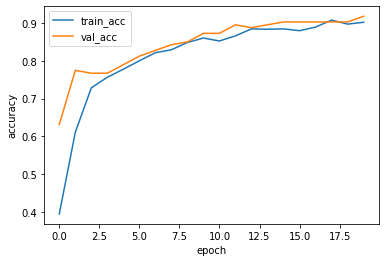

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc',"val_acc"], loc = 'best')
plt.show()

In [39]:
result = model.evaluate(test_ds)

1/1 [==============================] - 0s 491ms/step - loss: 0.2859 - accuracy: 0.8906


1/1 [==============================] - 0s 20ms/step


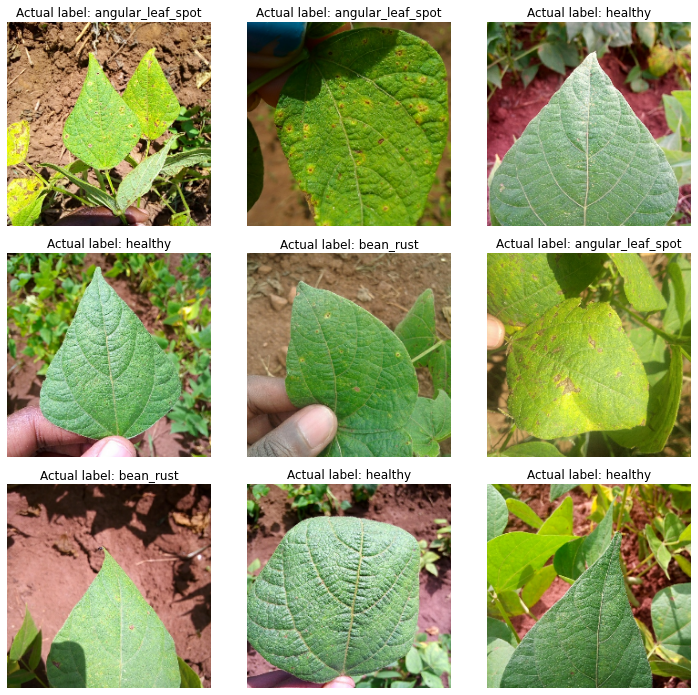

In [40]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)

    plt.tight_layout()

    img = tf.keras.preprocessing.image.img_to_array(images[i])
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual label: %s" % classes[np.argmax(pred)], fontsize=12)

    plt.axis('off')

In [41]:
model.save('./models', save_format="tf")

In [42]:
!ls -alrt models

total 1888
drwxr-xr-x 1 root root    4096 Dec  5 13:59 ..
drwxr-xr-x 2 root root    4096 Dec  5 13:59 variables
drwxr-xr-x 2 root root    4096 Dec  5 13:59 assets
-rw-r--r-- 1 root root 1906484 Dec  5 13:59 saved_model.pb
-rw-r--r-- 1 root root    6922 Dec  5 13:59 keras_metadata.pb
drwxr-xr-x 4 root root    4096 Dec  5 13:59 .


In [43]:
model_loaded = tf.keras.models.load_model('./models/')

In [44]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [45]:
from PIL import Image
import numpy as np
from skimage import transform
def process(filename):
  np_image = Image.open(filename)
  np_image = np.array(np_image).astype('float32')
  np_image = transform.resize(np_image, (224, 224, 3))
  np_image = np.expand_dims(np_image, axis = 0)
  return np_image

In [46]:
pred_label = model_loaded.predict(process('beans/train/healthy/healthy_train.0.jpg'))
print(classes[np.argmax(pred_label)])

1/1 [==============================] - 1s 811ms/step
healthy


In [47]:
pred_label

array([[0.00111423, 0.04936053, 0.94952524]], dtype=float32)

In [48]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/keras_metadata.pb (deflated 82%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/variables/variables.index (deflated 78%)
  adding: models/assets/ (stored 0%)
  adding: models/saved_model.pb (deflated 92%)


In [49]:
print(tf.__version__)


2.9.2


In [50]:
!ls

beans  models  models.zip  sample_data	test.zip  train.zip  validation.zip
